# A joint Density from Vanilla and Forward Starter Smiles

### Author | Max Chellew

## Libarys

In [1]:
## Import Python Libarys

# Libarys
import numpy as np 
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt

## Randomizor Seed

In [2]:
np.random.seed(2001)

## Black-Scholes and SVI Based Functions

In [3]:
## SVI based functions

# SVI Implied Variance 
def impVar(F, K, a, b, m, rho, sigma):

    # initalize variables
    x = np.log(K/F)

    # return Implied variance
    return a + b*(rho*(x-m) + np.sqrt((x-m)**2 + sigma**2))

# SVI Implied Volatility (sigma hat) 
def impVol(F, K, T, prm):

    # return implied volatility
    return np.sqrt((1/T)*impVar(F, K, *prm))

## Black-Scholes Based Functions

# Black Scholes Call option price (function)
def bsCall(St, K, tau, sigma, r):

    # Set d1 and d2 values
    d1=(1/(sigma*np.sqrt(tau)))*(np.log(St/K)+(r + 0.5*sigma**2)*(tau))
    d2=d1-sigma*np.sqrt(tau)

    # return black-scholes call price 
    return St*sp.stats.norm.cdf(d1) - K*sp.stats.norm.cdf(d2)

# Risk neutrual SVI Densities (breeden litzenberg)
def bsDensity(F, K, T, SVIprm, r, method):

    # Central Difference method (apromixation)
    if method == "central":

        # Set delta K
        deltaK = 10**(-3)

        # Set Forward, backward and central BS call price 
        CU = bsCall(F, K + deltaK, T, impVol(F, K + deltaK, T, SVIprm), r)
        CD = bsCall(F, K - deltaK, T, impVol(F, K - deltaK, T, SVIprm), r)
        CM = bsCall(F, K, T, impVol(F, K, T, SVIprm), r)

        # return black-scholes risk netural density via second order central difference method 
        return (CU + CD - 2*CM)/(deltaK**2)
    
    # SVI method when r=0
    if method == "exact":
        
        # log moneyness
        x = np.log(K/F)

        # SVI parmaters
        a = SVIprm.iloc[0]
        b = SVIprm.iloc[1]
        m = SVIprm.iloc[2]
        rho = SVIprm.iloc[3]
        sigma = SVIprm.iloc[4]

        w = a + b*( rho * (x-m) + np.sqrt((x-m)**2 + sigma**2) )
        dwdx = b*( rho + (x-m)/np.sqrt((x-m)**2 + sigma**2) )
        d2wdx2 = ( b * sigma**2 )/( ((x-m)**2 + sigma**2)**(1.5) )

        A = -np.exp(-(( 4 * x**2) + w**2)/(8 * w))
        B = -4 * ( x**2 ) * ( dwdx**2 ) + 4 * w * dwdx * ( 4 * x + dwdx ) + (w**2)*(dwdx**2 - 8*(2 + d2wdx2))
        C = 16 * ( np.exp(x)**1.5 ) * np.sqrt(2*np.pi) * (w**2.5)

        return A*B/C
    

def bsCDensity(F, K, T, SVIprm, r, method):

    # Central Difference method (apromixation)
    if method == "central":

        # Set delta K
        deltaK = 10**(-4)

        # Set Forward, backward and central BS call price 
        CU = bsCall(F, K + deltaK, T, impVol(F, K + deltaK, T, SVIprm), r)
        CM = bsCall(F, K - deltaK, T, impVol(F, K - deltaK, T, SVIprm), r)

        # return black-scholes risk netural cumaltive density via first order central difference method 
        return (CU - CM)/(2*deltaK) + 1
    
    # SVI method when r=0
    if method == "exact":

        # log moneyness
        x = np.log(K/F)

        # SVI parmaters
        a = SVIprm.iloc[0]
        b = SVIprm.iloc[1]
        m = SVIprm.iloc[2]
        rho = SVIprm.iloc[3]
        sigma = SVIprm.iloc[4]

        w = a + b * ( rho*(x-m) + np.sqrt((x-m)**2 + sigma**2) )
        dwdx = b *( rho + (x-m)/np.sqrt((x-m)**2 + sigma**2) )

        A = 2 * sp.special.erf( (2*x + w)/np.sqrt(8*w) )
        B = np.exp( -((4*x**2 + w**2)/(8*w)) )
        C = ( np.sqrt(2/np.pi)*dwdx)/(np.sqrt(np.exp(x)*w) )

        return (1/4)*(-2 + A + B*C) + 1

In [4]:
## Set SVI Densities and Prices

# SVI Density and Prices Class
class SVI:

    # set class variables
    def __init__(self, F, T, r, prm, method, dfunc, cdfunc, pfunc):
        self.F = F
        self.T = T
        self.r = r
        self.prm = prm
        self.method = method 
        self.dfunc = dfunc
        self.cdfunc = cdfunc
        self.pfunc = pfunc

    # imbeded density function 
    def density(self, K):

        # calculate densitiies
        A = self.dfunc(self.F, K, self.T, self.prm, self.r, self.method)

        # return densities
        return A
    
    def cdensity(self, K):

        # calculate densitiies
        A = self.cdfunc(self.F, K, self.T, self.prm, self.r, self.method)

        # return densities
        return A 
    
    def BSCPrice(self, K):
        sig = impVol(self.F, K, self.T, self.prm)
        return self.pfunc(self.F, K, self.T, sig, self.r)

## Data

In [5]:
## Create Dataframe (martin data)

# Forward Price Data (libary)
FPD = {"T1 Option": np.array(5489.83),
       "T2 Option": np.array(5509.62)}

# Strike Price Data (libary)
SPD = {"T1 Option": np.linspace(4500,5800,27),
       "T2 Option": np.linspace(4500,5850,28)}

# Implied Volatility Data (libary)
IVD = {"T1 Option": np.array([0.30833965626324,0.295476337981542,0.283463677875459,0.271111343370089,0.258451404309255,0.245507644865208,
                              0.233694271876973,0.221358004433688,0.209097873714426,0.197249412151294,0.186334324110301,0.174675684455109,
                              0.164666282229566,0.15488794443707,0.145823620475546,0.137304198281544,0.129231575271196,0.121548584918863,
                              0.114417742487412,0.108019587373161,0.102797547251224,0.0988783071539835,0.0959001836718852,0.0934990753558453,
                              0.0918556359282457,0.0918871975138243,0.0934062296063838]),
       "T2 Option": np.array([0.256852537,0.247760337,0.239148937,0.230164362,0.221471303,0.213216116,0.204941329,0.196782707,0.188796821,
                              0.18097782,0.173595754,0.166310667,0.159104289,0.152337857,0.145636895,0.139202498,0.13297359,0.127012094,
                              0.121383442,0.116175933,0.111556175,0.108039662,0.105025304,0.102493089,0.100737696,0.099359633,0.098369882,
                              0.098029772])}

# Time to maturity Data (libary)
TTM = {"T1 Option": np.array(20/251),
       "T2 Option": np.array(40/251)}

# Forward price, Strike price, Implied volatility data (pandas DataFrame)
data = pd.DataFrame(data=[FPD, SPD, IVD, TTM], index=["Forward", "Strike", "Implied Vol", "Time to Maturity"])

# Display dataframe
display(data)

,T1 Option,T2 Option
Forward,5489.83,5509.62
Strike,"[4500.0, 4550.0, 4600.0, 4650.0, 4700.0, 4750....","[4500.0, 4550.0, 4600.0, 4650.0, 4700.0, 4750...."
Implied Vol,"[0.30833965626324, 0.295476337981542, 0.283463...","[0.256852537, 0.247760337, 0.239148937, 0.2301..."
Time to Maturity,0.0796812749003984,0.1593625498007968


## Pre Set Paramaters

In [6]:
## Inialize strike and forward prices

# Forward prices 
FT1 = data.loc["Forward", "T1 Option"]
FT2 = data.loc["Forward", "T2 Option"]

# Strike prices
KT1 = data.loc["Strike", "T1 Option"]
KT2 = data.loc["Strike", "T2 Option"]

# More Strike Prices
K_T1 = np.linspace(np.min(KT1), np.max(KT1), 10000)
K_T2 = np.linspace(np.min(KT2), np.max(KT2), 10000)

# Modified Strike prices
kT1 = KT1/FT1
kT2 = KT2/FT2

# More modified Strike prices
k_T1 = np.linspace(np.min(kT1), np.max(kT1), 10000)
k_T2 = np.linspace(np.min(kT2), np.max(kT2), 10000)

# Global modifed stikes prices
k = np.linspace(0.7, 1.3, 1000)

# Time to matruity
T1 = data.loc["Time to Maturity", "T1 Option"]
T2 = data.loc["Time to Maturity", "T2 Option"]

## SVI parametrization

SVI implied volaitlity $ \hat{\sigma}(K)$ is defined by the SVI implied variance

$$ \hat{\sigma}(K)^2 T = a + b\Big(\rho(x-m) + \sqrt{(x-m)^2 + \sigma^2}\Big) $$

we can fit the SVI parmaters $a, b, m, \rho, \sigma$ to the observed cross smiles by minimising the following least sqaures problem

Let:

$$f(x_i, \beta) = \hat{\sigma}(K)^2 T = a + b\Big(\rho(x-m) + \sqrt{(x-m)^2 + \sigma^2}\Big)$$

where $x_i = \log(\frac{K_i}{F_0})$ and $\beta = (a, b, m, \rho, \sigma)$

Minimise:

$$  F(X, Y, \beta) = \sum^{n}_{i=1} (f(x_i, \beta) - y_i)^2 $$

where $X = (x_1, ..., x_n)$ are the log moneyness values and $Y = (y_1, ..., y_n)$ are the observed cross implied variance values 

Constraints: 

$$ 
\begin{aligned}

\sigma &\geq 0   \\

b &\geq 0 \\

|\rho| &\leq 1 \\

a + b\sigma \sqrt{1 - \rho^{2}} &\geq 0

\end{aligned}
$$

SVI Functions

In [7]:
## SVI Parameter Calibaration (set-Up)

# Least squares residuals (function) 
def res(x_, F, K, y, T):

    # Initalize variables
    a = x_[0]
    b = x_[1]
    m = x_[2]
    rho = x_[3]
    sigma = x_[4]
    x = np.log(K/F)

    # return residual value
    return np.abs((a + b*(rho*(x - m) + np.sqrt((x - m)**2 + sigma**2))) - (y**2)*T)

# SVI calibaration via least squared estimation (function)
def calibarationSVI(data):

    # Inital Parameter Guess
    p0 = [-0.005230, 0.045804, -0.073857, -0.603202, 0.161601]

    # Set input values
    F = data.iloc[0]
    K = data.iloc[1]
    y = data.iloc[2]
    T = data.iloc[3]

    # least squared minimisation
    prm_guess = sp.optimize.least_squares(res, p0, args=(F, K, y, T), 
                                          bounds=([-np.inf, 0, -np.inf, -1, 0.0001], [np.inf, np.inf, np.inf, 1, np.inf]), 
                                          method="dogbox")

    # return parameter guess
    return prm_guess.x

Return SVI parmaters

In [8]:
## SVI calibaration (exetution)

# Set SVI parameters
prmT1 = calibarationSVI(data["T1 Option"])
prmT2 = calibarationSVI(data["T2 Option"])

# SVI parmaeters (pandas DataFrame)
prm = pd.DataFrame(data = {"T1 Option": prmT1,
                           "T2 Option": prmT2},
                           index=["a", "b", "m", "rho", "sigma"])

# Display SVI calibrated SVI parameters
display(prm)

,T1 Option,T2 Option
a,-0.005230,-0.441598
b,0.045804,0.382873
m,-0.073857,0.401846
rho,-0.603202,0.275383
sigma,0.161601,1.203997


Plot SVI smiles along with market impled volatility

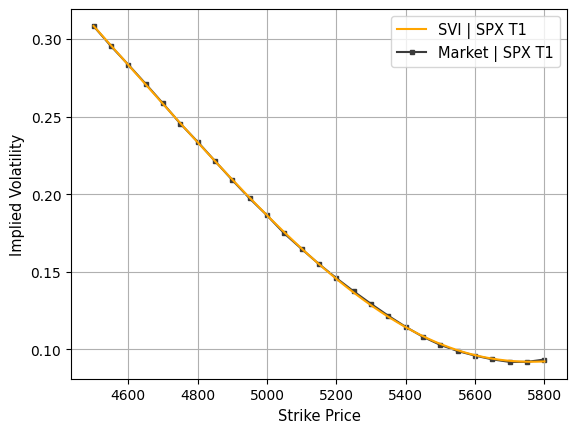

In [9]:
# T1 option smile plot
plt.grid()
plt.plot(K_T1, impVol(FT1, K_T1, T1, prm["T1 Option"]), zorder=2, color="orange")
plt.plot(data.loc["Strike", "T1 Option"], data.loc["Implied Vol", "T1 Option"], marker="s", markersize=3.5, color="#3b3b3b", zorder=1)
plt.xlabel("Strike Price", fontsize=10.5)
plt.ylabel("Implied Volatility", fontsize=10.5)
plt.legend(["SVI | SPX T1", "Market | SPX T1"], fontsize=10.5)

plt.savefig('T1_SVI_Mkt.png')

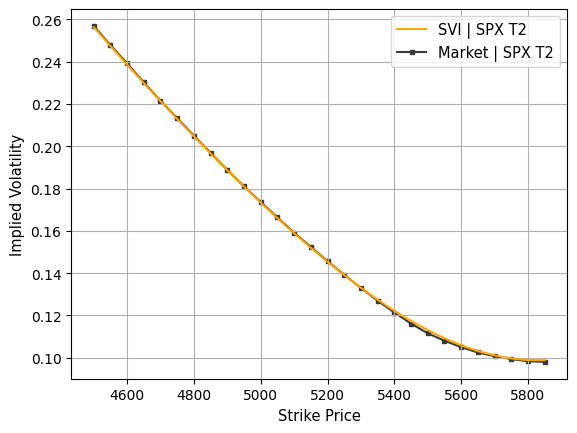

In [10]:
# T2 Option smile plot
plt.grid()
plt.plot(K_T2, impVol(FT2, K_T2, T2, prm["T2 Option"]), zorder=2, color="orange")
plt.plot(data.loc["Strike", "T2 Option"], data.loc["Implied Vol", "T2 Option"], marker="s", markersize=3.5, color="#3b3b3b", zorder=1)
plt.xlabel("Strike Price", fontsize=10.5)
plt.ylabel("Implied Volatility", fontsize=10.5)
plt.legend(["SVI | SPX T2", "Market | SPX T2"], fontsize=10.5)

plt.savefig('T2_SVI_Mkt.png')

## Risk-Neural Densities

Plot normalised densities

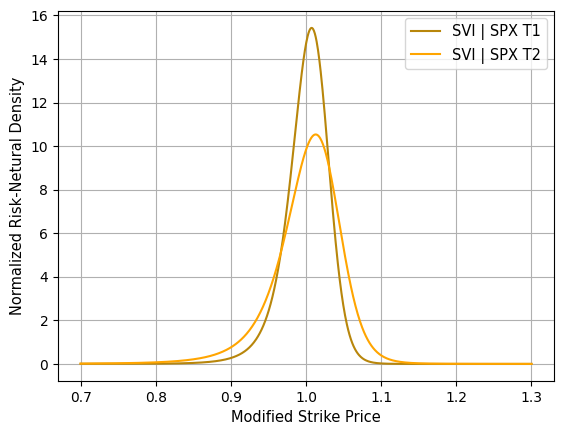

In [11]:
# Normalized SVI aproximated risk-netural densities (EUR/USD)

bsT1 = SVI(1, T1, 0, prm["T1 Option"], "exact", bsDensity, bsCDensity, bsCall)
bsT2 = SVI(1, T2, 0, prm["T2 Option"], "exact", bsDensity, bsCDensity, bsCall)

# Plot
plt.grid()
plt.plot(k, bsT1.density(k), zorder=2, color="darkgoldenrod")
plt.plot(k, bsT2.density(k), zorder=3, color="orange")
plt.xlabel("Modified Strike Price", fontsize=10.5)
plt.ylabel("Normalized Risk-Netural Density", fontsize=10.5)
plt.legend(["SVI | SPX T1", "SVI | SPX T2"], fontsize=10.5)


Check densities are valid by checking they are normalized and have a forward price of 1 and integrate to 1

In [12]:
## Check density integrals for mu_X, mu_Y and mu_Z,

# Print integral of mu_X w.r.t x
print("int mu_1 ds_1 = ", np.sum(bsT1.density(k))*((k)[1] - (k)[0]))

# Print integral of mu_Y w.r.t y
print("int mu_2 ds_2 = ", np.sum(bsT2.density(k))*((k)[1] - (k)[0]))

int mu_1 ds_1 =  0.9989304902703033
int mu_2 ds_2 =  0.9983403366686611


In [13]:
## Check expecations of X, Y and Z

# Print expecation of X
print("E(S_1/F_1) = ", np.sum((k) * bsT1.density(k))*((k)[1] - (k)[0]))

# Print expectation of Y
print("E(S_2/F_2) = ", np.sum((k) * bsT2.density(k))*((k)[1] - (k)[0]))

E(S_1/F_1) =  0.9993700314535156
E(S_2/F_2) =  0.9993267488789224


Check densities can price options correctly (cross comparison of SVI smile and Expations under risk-neatural densties)

In [14]:
# Set Up

# Set density classes (with modified strikes)
bsT1 = SVI(1, T1, 0, prm["T1 Option"], "exact", bsDensity, bsCDensity, bsCall)
bsT2 = SVI(1, T2, 0, prm["T2 Option"], "exact", bsDensity, bsCDensity, bsCall)

# Set inverse CDF functions
k1 = np.linspace(0.1, 1.2, 1000)
k2 = np.linspace(0.1, 1.25, 1000)

# Caculate prices and Root find smiles

# Calculate price using PDF (Expecation)
k_ = np.linspace(0.1, 1.23, 10000)
priceT1_pdf = np.sum(np.maximum(np.tile(k_, (len(kT1), 1)) - kT1.reshape(len(kT1), 1), 0)*bsT1.density(k_)*(k_[1]-k_[0]), axis=1)
priceT2_pdf = np.sum(np.maximum(np.tile(k_, (len(kT2), 1)) - kT2.reshape(len(kT2), 1), 0)*bsT2.density(k_)*(k_[1]-k_[0]), axis=1)

# root find smiles
def rootsigma(sigma):
    return bsCall(1, kT1, T1, sigma, 0) - priceT1_pdf
smileT1_pdf = sp.optimize.root(rootsigma, np.repeat(1, len(kT1))).x
def rootsigma(sigma):
    return bsCall(1, kT2, T2, sigma, 0) - priceT2_pdf
smileT2_pdf = sp.optimize.root(rootsigma, np.repeat(1, len(kT2))).x

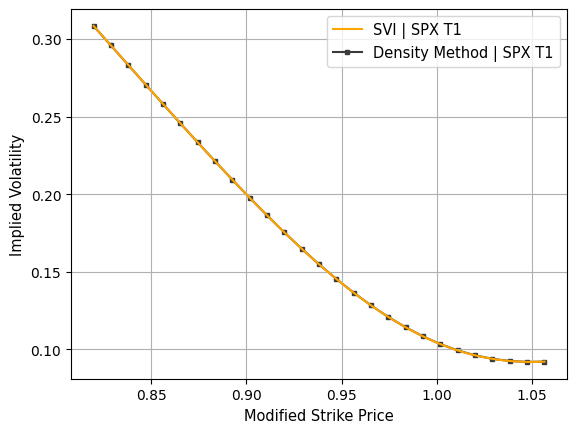

In [15]:
# T1 days to maturity smile plot
plt.grid()
plt.plot(k_T1, impVol(FT1, K_T1, T1, prm["T1 Option"]), zorder=3, color="orange")
plt.plot(kT1, smileT1_pdf, marker="s", markersize=3.5, color="#3b3b3b", zorder=1)
plt.ylabel("Implied Volatility", fontsize=10.5)
plt.xlabel("Modified Strike Price", fontsize=10.5)
plt.legend(["SVI | SPX T1", "Density Method | SPX T1"], fontsize=10.5)

plt.savefig('T1_SVI_pdf_cdf.png')

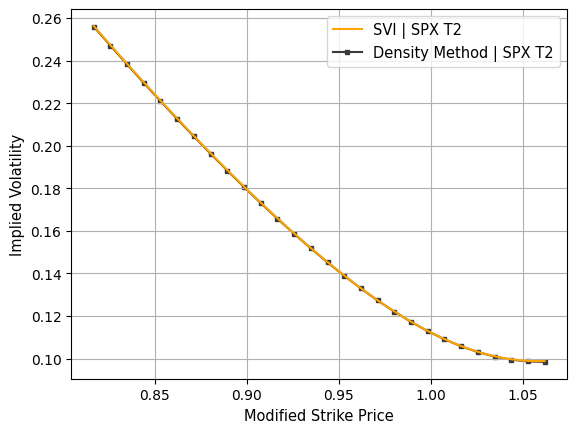

In [16]:
# T2 to maturity smile plot
plt.grid()
plt.plot(k_T2, impVol(FT2, K_T2, T2, prm["T2 Option"]), color="orange", zorder=3)
plt.plot(kT2, smileT2_pdf, marker="s", markersize=3.5, color="#3b3b3b", zorder=1)
plt.ylabel("Implied Volatility", fontsize=10.5)
plt.xlabel("Modified Strike Price", fontsize=10.5)
plt.legend(["SVI | SPX T2", "Density Method | SPX T2"], fontsize=10.5)
plt.savefig('T2_SVI_pdf_cdf.png')

Plot SVI CDF density For T1

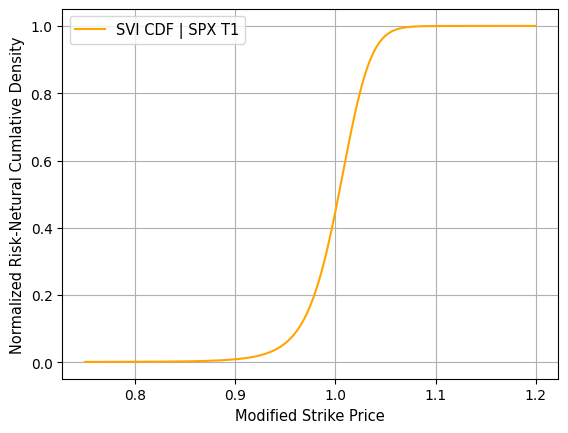

In [17]:
k_cdf = np.linspace(0.75, 1.2, 200)
plt.grid()
plt.plot(k_cdf, bsT1.cdensity(k_cdf), color="orange")
plt.xlabel("Modified Strike Price", fontsize=10.5)
plt.ylabel("Normalized Risk-Netural Cumlative Density", fontsize=10.5)
plt.legend(["SVI CDF | SPX T1"], fontsize=10.5)


plt.savefig('T1_SVI_cdf.png')

Check inverse CDF monte-carlo can price options correctly (cross comparion of SVI smile and inverse CDF monte carlo smile)

In [18]:
# simulate ST1 using inverse CDF method

k_ = np.linspace(0.01, 1.4, 10000)
invCDFT1 = sp.interpolate.CubicSpline(bsT1.cdensity(k_), k_)

# number of simulations
N = 200000

# simulate uniform random variables (antithetic variables)
stnd_uni_rand = np.random.uniform(0.0001,1-0.0001, int(N/2))
anti_uni_rand = 1 - stnd_uni_rand
uni_rand = np.append(stnd_uni_rand, anti_uni_rand)

ST1 = invCDFT1(uni_rand)

# ST2 smile from LVG
priceT1_inv = np.average(np.maximum(np.tile(ST1, (len(kT1), 1)) - kT1.reshape(len(kT1), 1), 0), axis=1)
def rootsigma(sigma):
    return bsCall(1, kT1, T1, sigma, 0) - priceT1_inv
smileT1_inv = sp.optimize.root(rootsigma, np.repeat(0.5, len(kT1))).x

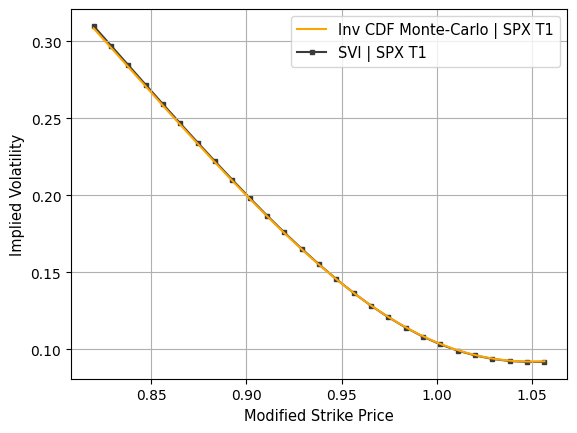

In [19]:
plt.grid()
plt.plot(k_T1, impVol(FT1, K_T1, T1, prm["T1 Option"]), zorder=2, color="orange")
plt.plot(kT1, smileT1_inv, marker="s", markersize=3.5, color="#3b3b3b", zorder=1)
plt.xlabel("Modified Strike Price", fontsize=10.5)
plt.ylabel("Implied Volatility", fontsize=10.5)
plt.legend(["Inv CDF Monte-Carlo | SPX T1", "SVI | SPX T1"], fontsize=10.5)

plt.savefig('T2_SVI_LVG.png')

# Creating Forward Starter Smile using Inverse CDF monte-carlo and LVG monte-carlo

Calibrate and Plot calibrated local diffusion coeficient for two matruity LVG model

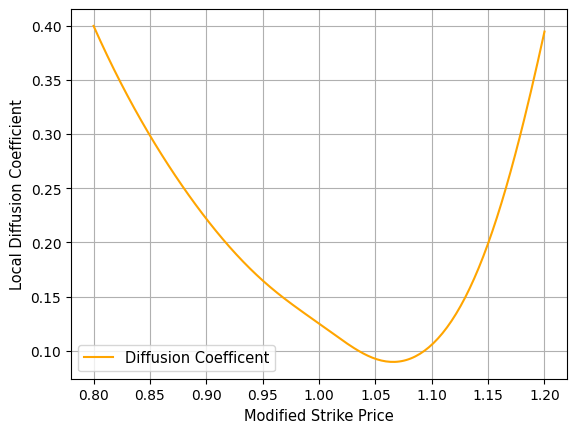

In [20]:
## Diffusion coeficient calibration between T1 and T2

# normalied stirk prices
k = np.linspace(0.1, 1.4, 10000)
ak = np.linspace(0.8, 1.2, 200)

# calibrate local diffusion function
a2 = (2/T1)*((bsT2.BSCPrice(k) - bsT1.BSCPrice(k))/bsT2.density(k))
a2_func = sp.interpolate.CubicSpline(k, np.sqrt(a2))

# plot
plt.grid()
plt.plot(ak, a2_func(ak), color="orange")
plt.xlabel("Modified Strike Price", fontsize=10.5)
plt.ylabel("Local Diffusion Coefficient", fontsize=10.5)
plt.legend(["Diffusion Coefficent"], fontsize=10.5)

# save plot
plt.savefig('T12_diffusion.png')

perform monte-carlo simulation of LVG model

In [21]:
# gamma distribution parameters
t_ = T1

# Set No. Time steps
n = 200
# Set Change in normal time 
dt = T1/n

# set up martix
ST12 = np.zeros([N, n+1])
ST12[:, 0] = ST1

# simulate paths
for i in range(1, n+1):
    # time count

    # random samples
    dG = np.random.gamma(dt/t_, t_, N)
    dW = np.random.normal(0, np.sqrt(dG), N)

    ST12[:, i] =  ST12[:, i-1] + a2_func(ST12[:, i-1])*dW

ST2_LVG = ST12[:, -1]

Plot LVG simulation

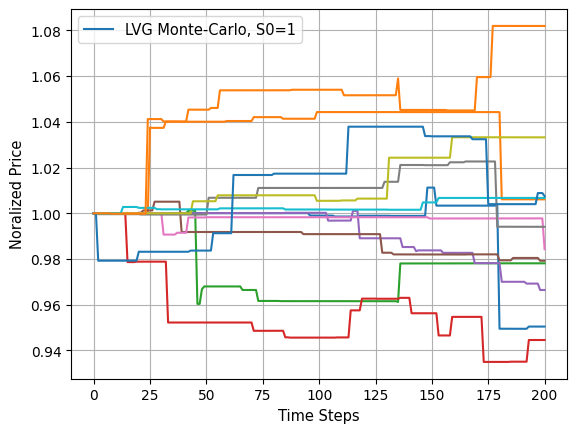

In [22]:
plt.grid()
for i in range(12):
    plot = [1]
    for j in range(1, n+1):
        dG = np.random.gamma(dt/t_, t_)
        dW = np.random.normal(0, np.sqrt(dG))
        plot.append(plot[-1] + a2_func(plot[-1])*dW)
    plt.plot(np.array(plot))
plt.xlabel("Time Steps", fontsize=10.5)
plt.ylabel("Noralized Price", fontsize=10.5)
plt.legend(["LVG Monte-Carlo, S0=1"], fontsize=10.5)

plt.savefig('LVG_SIM.png')

Plot forward starter smile

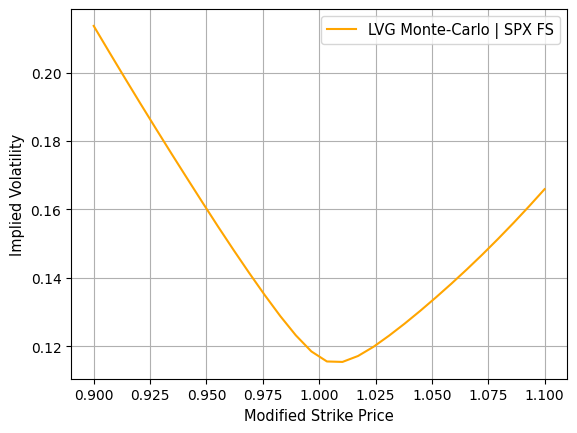

In [23]:
# FS smile from LVG
kfs = np.linspace(0.9, 1.1, 30)
priceFS_LVG = np.average(np.maximum(np.tile((ST2_LVG*FT2)/(ST1*FT1), (len(kfs), 1)) - kfs.reshape(len(kfs), 1), 0), axis=1)
def rootsigma(sigma):
    return bsCall(FT2/FT1, kfs, (T2-T1), sigma, 0) - priceFS_LVG
smileFS_LVG = sp.optimize.root(rootsigma, np.repeat(0.5, len(kfs)), method="lm").x

# T2 to maturity smile plot
plt.grid()
plt.plot(kfs, smileFS_LVG, color="orange")
plt.xlabel("Modified Strike Price", fontsize=10.5)
plt.ylabel("Implied Volatility", fontsize=10.5)
plt.legend(["LVG Monte-Carlo | SPX FS"], fontsize=10.5)

plt.savefig('FS_LVG.png')

## Forward Starter SVI smile

In [24]:
## Create Dataframe (martin data)

# Forward Price Data (libary)
FPD = {"FS Option": np.array(FT2/FT1)}

# Strike Price Data (libary)
SPD = {"FS Option": np.array(kfs)}

# Implied Volatility Data (libary)
IVD = {"FS Option": np.array(smileFS_LVG)}

# Time to maturity Data (libary)
TTM = {"FS Option": np.array(20/251)}

# Forward price, Strike price, Implied volatility data (pandas DataFrame)
dataFS = pd.DataFrame(data=[FPD, SPD, IVD, TTM], index=["Forward", "Strike", "Implied Vol", "Time to Maturity"])

# append data 
data12FS = pd.concat([data, dataFS], axis=1)

# Display dataframe
display(data12FS)

,T1 Option,T2 Option,FS Option
Forward,5489.83,5509.62,1.0036048475089392
Strike,"[4500.0, 4550.0, 4600.0, 4650.0, 4700.0, 4750....","[4500.0, 4550.0, 4600.0, 4650.0, 4700.0, 4750....","[0.9, 0.906896551724138, 0.9137931034482759, 0..."
Implied Vol,"[0.30833965626324, 0.295476337981542, 0.283463...","[0.256852537, 0.247760337, 0.239148937, 0.2301...","[0.21361833188787807, 0.20597652459675794, 0.1..."
Time to Maturity,0.0796812749003984,0.1593625498007968,0.0796812749003984


In [25]:
## SVI calibaration (exetution)

# Set SVI parameters
prmFS = calibarationSVI(data12FS["FS Option"])

# SVI parmaeters (pandas DataFrame)
prmFS = pd.DataFrame(data = {"FS Option": prmFS},
                           index=["a", "b", "m", "rho", "sigma"])

# append prm
prm12FS = pd.concat([prm, prmFS], axis=1)

# Display SVI calibrated SVI parameters
display(prm12FS)

bsFS = SVI(1, T1, 0, prm12FS["FS Option"], "exact", bsDensity, bsCDensity, bsCall)

,T1 Option,T2 Option,FS Option
a,-0.005230,-0.441598,-0.000033
b,0.045804,0.382873,0.026470
m,-0.073857,0.401846,-0.003563
rho,-0.603202,0.275383,-0.222551
sigma,0.161601,1.203997,0.043339


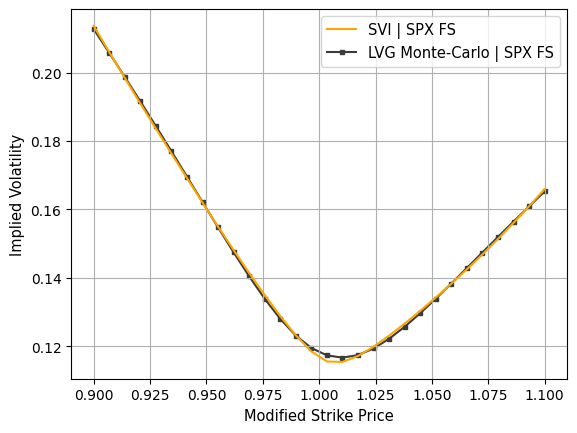

In [26]:
plt.grid()
plt.plot(kfs, smileFS_LVG, color="orange", zorder=2)
plt.plot(kfs, impVol(data12FS.loc["Forward", "FS Option"], kfs, data12FS.loc["Time to Maturity", "FS Option"], prm12FS["FS Option"]), 
         marker="s", markersize=3.5, zorder=1, color="#3b3b3b")
plt.xlabel("Modified Strike Price", fontsize=10.5)
plt.ylabel("Implied Volatility", fontsize=10.5)
plt.legend(["SVI | SPX FS", "LVG Monte-Carlo | SPX FS"], fontsize=10.5)

plt.savefig('FS_SVI_LVG.png')

## Distributions

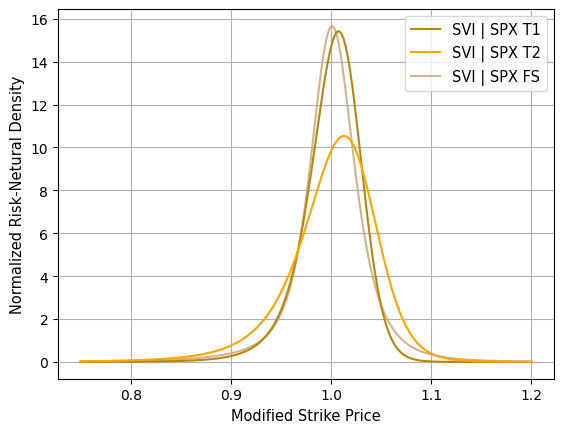

In [27]:
# Plot
k_ = np.linspace(0.75, 1.2, 200)
plt.grid()
plt.plot(k_, bsT1.density(k_), zorder=2, color="darkgoldenrod")
plt.plot(k_, bsT2.density(k_), zorder=3, color="orange")
plt.plot(k_, bsFS.density(k_), color="tan",  zorder=1)
plt.xlabel("Modified Strike Price", fontsize=10.5)
plt.ylabel("Normalized Risk-Netural Density", fontsize=10.5)
plt.legend(["SVI | SPX T1", "SVI | SPX T2", "SVI | SPX FS"], fontsize=10.5)

plt.savefig('FS_SVI_normDensity.png')

## Sinkhorn scheme

In [28]:
## modifed Cubic Spline Function (removes any extrpolation)

def cs(x_, x, f):

    # Set cubic spline function
    spline = sp.interpolate.CubicSpline(x, f)
    
    # set values outside [min(z), max(z)] to zero
    f_x = spline(x_)
    f_x[x_ < np.min(x)] = 0
    f_x[x_ > np.max(x)] = 0

    return f_x

In [31]:
## Sinkhorn Scheme 

# Initalize Values 
s2 = np.linspace(0.1, 1.18, 100) # domain of S_T2
s1 = np.linspace(0.75, 1.15, 100) # domain of S_T1
fs = np.linspace(0.4, 1.5, 100) # domain of S_T2/S_T1
fs_hat = s2.reshape(len(s2), 1)/s1 # s2/s1 for u 
fs_bar = s2/s1.reshape(len(s1), 1) # s2/s1 for v and delta
s2_til = fs.reshape(len(fs), 1)*s1 # s1*sfs for w

# initalize densities

# mu_ST2
mu2 = bsT2.density(s2)
#mu2[mu2 <= 0] = 0.000001 # dealing with negative values
mu2_til = bsT2.density(s2_til)
#mu2_til[mu2_til <= 0] = 0.000001 # dealing with negative values

# mu_ST1
mu1 = bsT1.density(s1)
#mu1[mu1 <= 0] = 0.000001 # dealing with negative values

# mu_SFS
mufs = bsFS.density(fs)
#mufs[mufs <= 0] = 0.000001 # dealing with negative values
s = np.linspace(0.1, 1.6, 1000)
sig = np.sum(a2_func(s)*bsT1.density(s)*(s[1]-s[0]))

# T
T_hat = sp.stats.norm.pdf(s2.reshape(len(s2), 1), s1, np.sqrt(T1)*sig)
T_bar = sp.stats.norm.pdf(s2, s1.reshape(len(s1), 1), np.sqrt(T1)*sig)
T_til = sp.stats.norm.pdf(s2_til, s1, np.sqrt(T1)*sig)

In [32]:
# Sinkhorn Scheme 

# iteration

# u_0, v_0, w_0
u = v = w = delta = 0

# 1st iteration 

# u_1
u = np.log(mu1) - np.log(np.sum(mu1.reshape(len(mu1), 1) * T_bar *(s2[1]-s2[0]), axis=1))

# v_1
v = np.log(mu2) - np.log(np.sum(mu1 * T_hat * np.exp(u) * (s1[1]-s1[0]), axis=1))

# w_1 
w = np.log(mufs) - np.log(np.sum(s1 * mu1 * T_til * np.exp(u + cs(s2_til, s2, v)) * (s1[1]-s1[0]), axis=1))

# delta_1
def J(delta):
    A = np.sum((s2 - s1.reshape(len(s1), 1)) * T_bar * np.exp(u.reshape(len(u), 1) + v + cs(fs_bar, fs, w) + (s2 - s1.reshape(len(s1), 1))*delta.reshape(len(delta), 1)) * (s2[1]-s2[0]), axis=1)
    #A[np.abs(A) < 10**(-30)] = 0 # options={"maxiter":200}
    return A
delta = sp.optimize.root(J, np.repeat(0.0001, 100), method="lm").x
#delta = np.repeat(0.000, 200)

# nth iteration 
for i in range(49):
    # u_n
    u = np.log(mu1) - np.log(np.sum(mu1.reshape(len(mu1), 1) * T_bar * np.exp(v + cs(fs_bar, fs, w) + (s2 - s1.reshape(len(s1), 1))*delta.reshape(len(delta), 1)) * (s2[1]-s2[0]), axis=1))

    # v_n
    v = np.log(mu2) - np.log(np.sum(mu1 * T_hat * np.exp(u + cs(fs_hat, fs, w) + (s2.reshape(len(s2), 1) - s1)*delta) * (s1[1]-s1[0]), axis=1))

    # w_n
    w = np.log(mufs) - np.log(np.sum(s1 * mu1 * T_til * np.exp(u + cs(s2_til, s2, v) + s1*(fs.reshape(len(fs), 1) - 1)*delta) * (s1[1]-s1[0]), axis=1))

    # delta_1
    def J(delta):
        A = np.sum((s2 - s1.reshape(len(s1), 1)) * T_bar * np.exp(u.reshape(len(u), 1) + v + cs(fs_bar, fs, w) + (s2 - s1.reshape(len(s1), 1))*delta.reshape(len(delta), 1)) * (s2[1]-s2[0]), axis=1)
        return A
    delta = sp.optimize.root(J, delta, method="lm").x

## Joint density Calibration Check

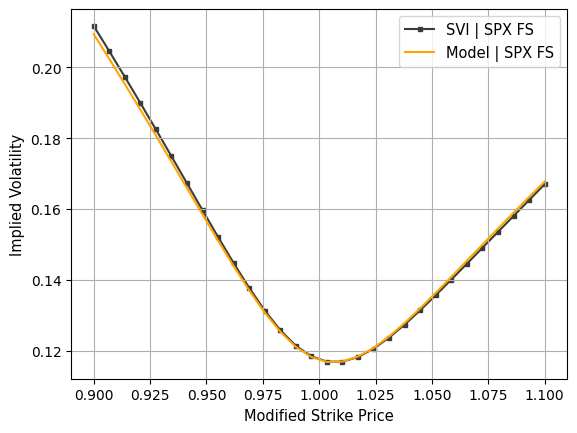

In [33]:
# check forward starter smile 

# find forward starter smile
smile = []
for i in range(len(kfs)):
    price = np.sum(np.sum(np.maximum(fs_bar - kfs[i], 0) * np.exp(u.reshape(len(u), 1) + v + cs(fs_bar, fs, w) + (s2 - s1.reshape(len(s1), 1))*delta.reshape(len(delta), 1)) * mu1.reshape(len(mu1), 1) * T_bar, axis=1)*(s2[1] -s2[0]))*(s1[1]-s1[0])
    def rootsigma(sigma):
        return bsCall(1, kfs[i], (T2-T1), sigma, 0) - price
    smile.append(sp.optimize.root(rootsigma, 1).x[0])

# plot smile
plt.grid()
plt.plot(kfs, smile, color="#3b3b3b", marker="s", markersize=3.5, zorder=1)
plt.plot(kfs, impVol(1, kfs, data12FS.loc["Time to Maturity", "FS Option"], prm12FS["FS Option"]), color="orange")
plt.xlabel("Modified Strike Price", fontsize=10.5)
plt.ylabel("Implied Volatility", fontsize=10.5)
plt.legend(["SVI | SPX FS", "Model | SPX FS"], fontsize=10.5)

plt.savefig('FS_SVI_Mdl.png')

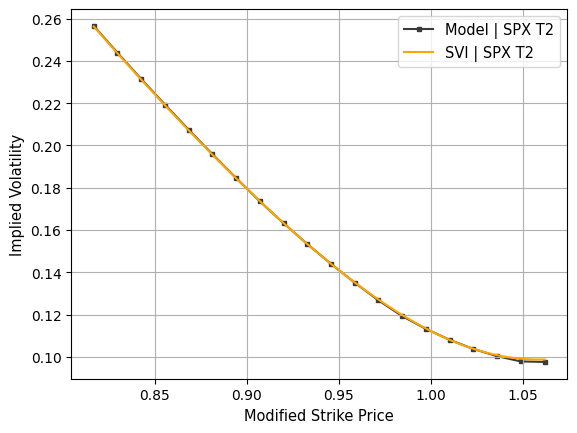

In [49]:
# check T2 smile 

# find t2 smile
k_T2 = np.linspace(np.min(kT2), np.max(kT2), 20)
smile2 = []
for i in range(len(k_T2)):
    mu = np.sum(np.exp(u + v.reshape(len(v), 1) + cs(fs_hat, fs, w) + (s2.reshape(len(s2), 1) - s1)*delta) * mu1 * T_hat, axis=1)*(s1[1] - s1[0])
    price = np.sum(np.maximum(s2 - k_T2[i], 0) * mu)*(s2[1]-s2[0])
    def rootsigma(sigma):
        return bsCall(1, k_T2[i], T2, sigma, 0) - price
    smile2.append(sp.optimize.root(rootsigma, 1).x[0])

# plot
plt.grid()
plt.plot(k_T2, smile2, color="#3b3b3b", marker="s", markersize=3.5, zorder=1)
plt.plot(K_T2/FT2, impVol(FT2, K_T2, T2, prm["T2 Option"]), zorder=2, color="orange")
plt.xlabel("Modified Strike Price", fontsize=10.5)
plt.ylabel("Implied Volatility", fontsize=10.5)
plt.legend(["Model | SPX T2", "SVI | SPX T2"], fontsize=10.5)

plt.savefig('T2_SVI_Mdl.png')

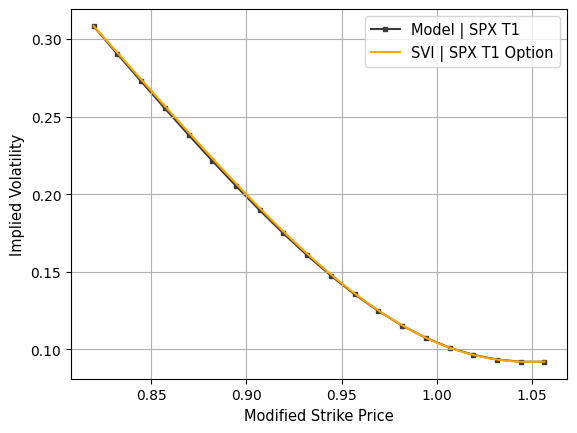

In [48]:
#check T1 smile 

# Find T1 smile 
k_T1 = np.linspace(np.min(kT1), np.max(kT1), 20)
smile1 = []
for i in range(len(k_T1)):
    mu = np.sum(np.exp(u.reshape(len(u), 1) + v + cs(fs_bar, fs, w) + (s2 - s1.reshape(len(s1), 1))*delta.reshape(len(delta), 1)) * mu1.reshape(len(mu1), 1) * T_bar, axis=1)*(s2[1] -s2[0])
    price = np.sum(np.maximum(s1 - k_T1[i], 0) * mu)*(s1[1]-s1[0])
    def rootsigma(sigma):
        return bsCall(1, k_T1[i], T1, sigma, 0) - price
    smile1.append(sp.optimize.root(rootsigma, 1).x[0])

# Plot
plt.grid()
plt.plot(k_T1, smile1, color="#3b3b3b", marker="s", markersize=3.5, zorder=1)
plt.plot(K_T1/FT1, impVol(FT1, K_T1, T1, prm["T1 Option"]), zorder=2, color="orange")
plt.xlabel("Modified Strike Price", fontsize=10.5)
plt.ylabel("Implied Volatility", fontsize=10.5)
plt.legend(["Model | SPX T1", "SVI | SPX T1 Option"], fontsize=10.5)

plt.savefig('T1_SVI_Mdl.png')

## Additonal graphs

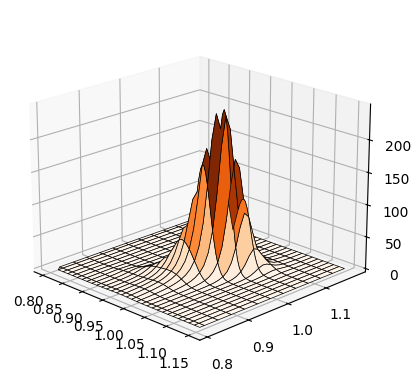

<Figure size 640x480 with 0 Axes>

In [36]:
# Grab some test data.
ax_X = np.tile(s1.reshape(len(s1), 1), (1, len(s1)))
ax_Y = np.tile(s2, (len(s2), 1))
ax_Z = np.exp(u.reshape(len(u), 1) + v + cs(fs_bar, fs, w) + (s2 - s1.reshape(len(s1), 1))*delta.reshape(len(delta), 1)) * mu1.reshape(len(mu1), 1) * T_bar

ax_X[ax_X < 0.8] = np.nan
ax_Z[ax_X < 0.8] = np.nan
ax_X[ax_X > 1.15] = np.nan
ax_Z[ax_X > 1.15] = np.nan

ax_Y[ax_Y < 0.8] = np.nan
ax_Z[ax_Y < 0.8] = np.nan
ax_Y[ax_Y > 1.2] = np.nan
ax_Z[ax_Y > 1.2] = np.nan

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(ax_X, ax_Y, ax_Z, cmap="Oranges", lw=0.5, rstride=3, cstride=3, edgecolor="black", shade=False, antialiased=True, label="Joint Density")

ax.view_init(elev=20., azim=-45, roll=0)

plt.show()

plt.savefig('FS_Joint_Density.png')

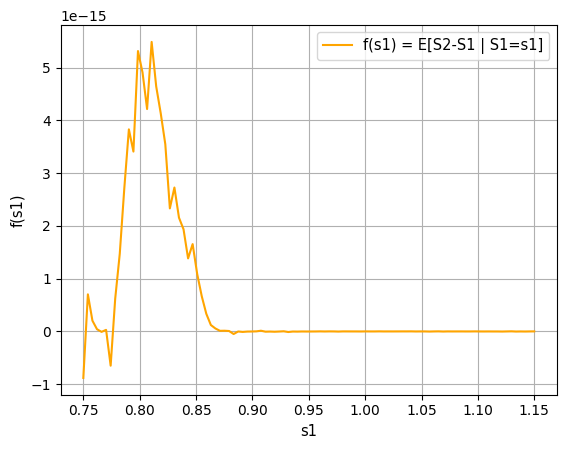

In [37]:
# Check martingle constraint

# Plot
plt.grid()
plt.plot(s1, np.sum((s2 - s1.reshape(len(s1), 1)) * T_bar * np.exp(u.reshape(len(u), 1) + v + cs(fs_bar, fs, w) + (s2 - s1.reshape(len(s1), 1))*delta.reshape(len(delta), 1)) * (s2[1]-s2[0]), axis=1), color="orange")
plt.legend(["f(s1) = E[S2-S1 | S1=s1]"], fontsize=10.5)
plt.xlabel("s1", fontsize=10.5)
plt.ylabel("f(s1)", fontsize=10.5)

plt.savefig('Marginal_v1.png')

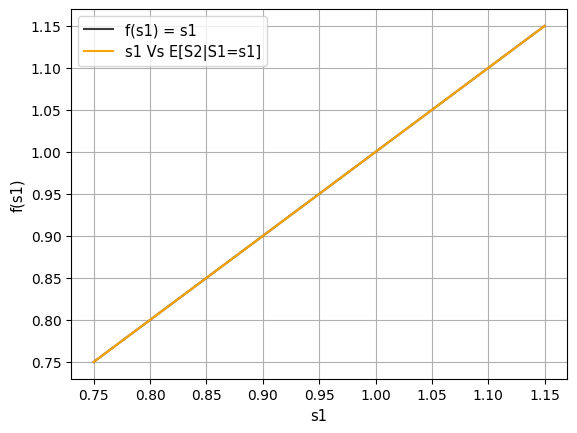

In [38]:
# Check martingle constraint

# normalizing constant for conditional distribution
B = np.sum(T_bar * np.exp(u.reshape(len(u), 1) + v + cs(fs_bar, fs, w) + (s2 - s1.reshape(len(s1), 1))*delta.reshape(len(delta), 1)) * (s2[1]-s2[0]), axis=1)
# conditonal expecation
A = np.sum((s2) * T_bar * np.exp(u.reshape(len(u), 1) + v + cs(fs_bar, fs, w) + (s2 - s1.reshape(len(s1), 1))*delta.reshape(len(delta), 1)) * (s2[1]-s2[0]), axis=1)/B

# plot
plt.grid()
plt.plot(s1, s1, color="#3b3b3b")
plt.plot(s1, A, color="orange")
plt.legend(["f(s1) = s1", "s1 Vs E[S2|S1=s1]"], fontsize=10.5)
plt.xlabel("s1", fontsize=10.5)
plt.ylabel("f(s1)", fontsize=10.5)

plt.savefig('Marginal_v2.png')

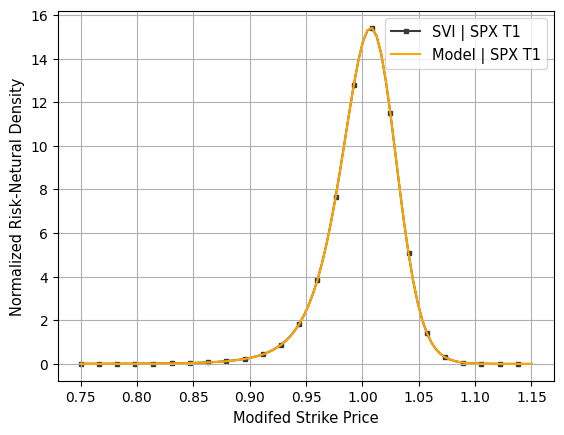

In [39]:
# check maringle constant s1

plt.grid()
plt.plot(s1, np.sum(np.exp(u.reshape(len(u), 1) + v + cs(fs_bar, fs, w) + (s2 - s1.reshape(len(s1), 1))*delta.reshape(len(delta), 1)) * mu1.reshape(len(mu1), 1) * T_bar, axis=1)*(s2[1] -s2[0]),
         color="#3b3b3b", marker="s", markersize=3.5, markevery=4, zorder=1)
plt.plot(s1, mu1,  zorder=2, color="orange")
plt.xlabel("Modifed Strike Price", fontsize=10.5)
plt.ylabel("Normalized Risk-Netural Density", fontsize=10.5)
plt.legend(["SVI | SPX T1", "Model | SPX T1"], fontsize=10.5)

plt.savefig('T1_SVI_Mdl_Density.png')

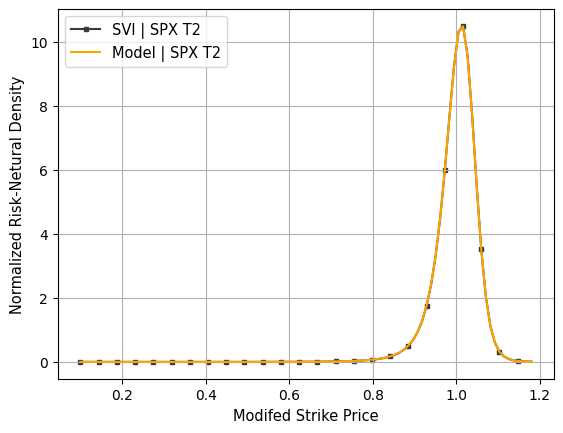

In [40]:
# check marginal constrant s2

plt.grid()
plt.plot(s2, np.sum(np.exp(u + v.reshape(len(v), 1) + cs(fs_hat, fs, w) + (s2.reshape(len(s2), 1) - s1)*delta) * mu1 * T_hat, axis=1)*(s1[1] - s1[0]),
         color="#3b3b3b", marker="s", markersize=3.5, markevery=4, zorder=1)
plt.plot(s2, mu2, zorder=2, color="orange")
plt.xlabel("Modifed Strike Price", fontsize=10.5)
plt.ylabel("Normalized Risk-Netural Density", fontsize=10.5)
plt.legend(["SVI | SPX T2", "Model | SPX T2"], fontsize=10.5)

plt.savefig('T2_SVI_Mdl_Density.png')

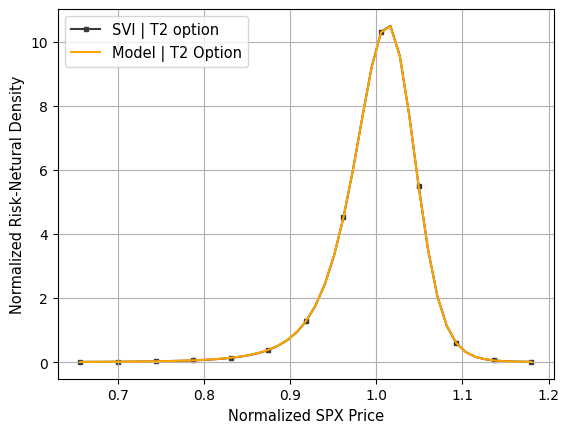

In [41]:
# check marginal constant s2 on smaller bound 

plt.grid()
plt.plot(s2[s2>0.65], (np.sum(np.exp(u + v.reshape(len(v), 1) + cs(fs_hat, fs, w) + (s2.reshape(len(s2), 1) - s1)*delta) * mu1 * T_hat, axis=1)*(s1[1] - s1[0]))[s2>0.65],
         color="#3b3b3b", marker="s", markersize=3.5, markevery=4, zorder=1)
plt.plot(s2[s2>0.65], mu2[s2>0.65], zorder=2, color="orange")
plt.xlabel("Normalized SPX Price", fontsize=10.5)
plt.ylabel("Normalized Risk-Netural Density", fontsize=10.5)
plt.legend(["SVI | T2 option", "Model | T2 Option"], fontsize=10.5)

plt.savefig('T2_SVI_Mdl_Density_small.png')

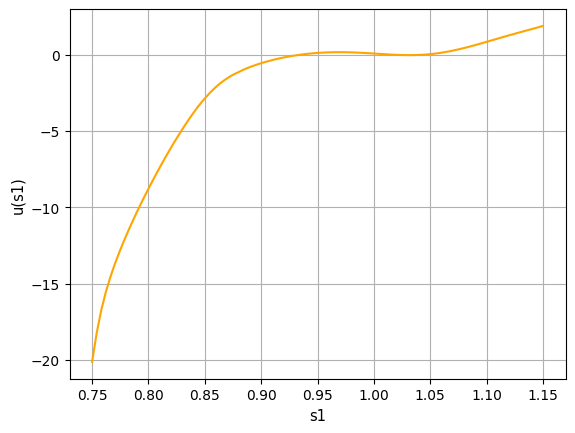

In [42]:
# u plot 

plt.grid()
plt.plot(s1, u, color="orange")
plt.xlabel("s1", fontsize=10.5)
plt.ylabel("u(s1)", fontsize=10.5)

plt.savefig('u_s1.png')

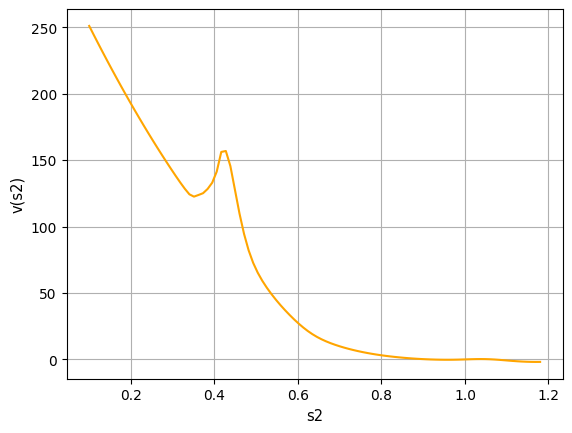

In [43]:
# v plot 

plt.grid()
plt.plot(s2, v, color="orange")
plt.xlabel("s2", fontsize=10.5)
plt.ylabel("v(s2)", fontsize=10.5)

plt.savefig('v_s2.png')

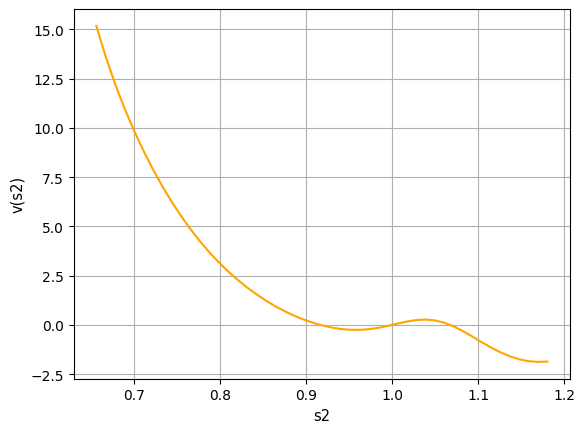

In [44]:
# v plot smaller bounds

plt.grid()
plt.plot(s2[s2>0.65], v[s2>0.65], color="orange")
plt.xlabel("s2", fontsize=10.5)
plt.ylabel("v(s2)", fontsize=10.5)

plt.savefig('v_s2_small.png')

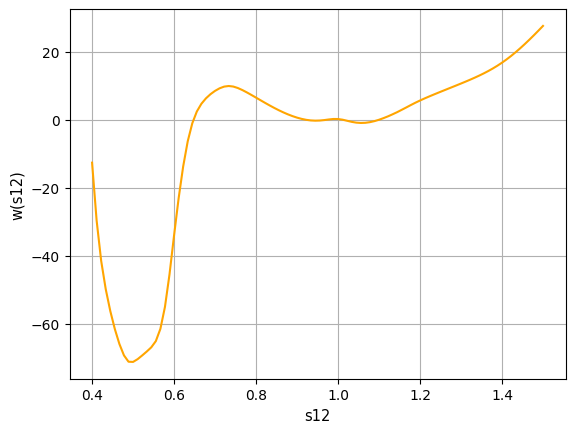

In [45]:
# w plot

plt.grid()
plt.plot(fs, w, color="orange")
plt.xlabel("s12", fontsize=10.5)
plt.ylabel("w(s12)", fontsize=10.5)

plt.savefig('w_s12.png')

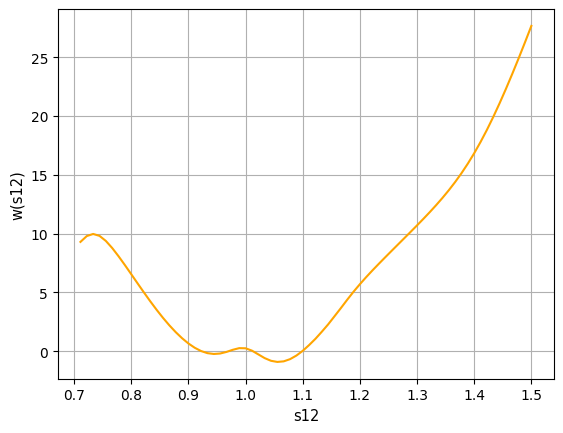

In [46]:
# w plot smaller bounds

plt.grid()
plt.plot(fs[fs>0.7], w[fs>0.7], color="orange")
plt.xlabel("s12", fontsize=10.5)
plt.ylabel("w(s12)", fontsize=10.5)

plt.savefig('w_s12_small.png')

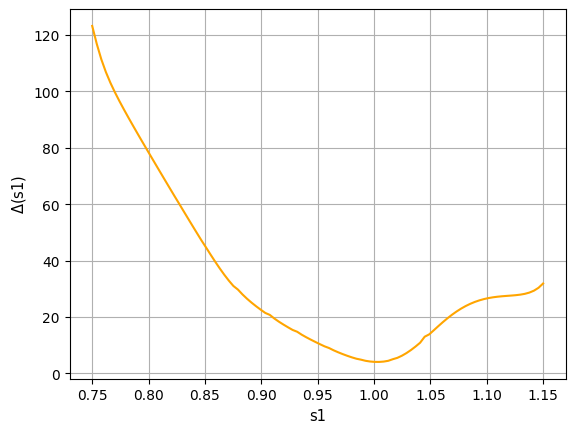

In [47]:
# delta plot 

plt.grid()
plt.plot(s1, delta, color="orange")
plt.xlabel("s1", fontsize=10.5)
plt.ylabel("$\Delta$(s1)", fontsize=10.5)

plt.savefig('Delta_s1.png')